<a href="https://colab.research.google.com/github/jademuun/car_insurance_MTPL/blob/master/Neural_nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python3 --version

Python 3.7.10


In [2]:
!pip install probflow

     |████████████████████████████████| 102kB 3.8MB/s 


# Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from seaborn import countplot
from matplotlib.pyplot import figure, show
import timeit

from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, r2_score

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from tensorflow.keras.layers.experimental import preprocessing
from keras import backend as K

import probflow as pf

# Functions

In [35]:
# plotting the loss
def plot_loss(history, yran,  measure = 'loss',
              valmeasure = 'val_loss', val = True):
  plt.plot(history.history[measure], label=measure)
  if val:
    plt.plot(history.history[valmeasure], label=valmeasure)
  plt.ylim(yran)
  plt.xlabel('Epoch')
  plt.ylabel('Deviance')
  plt.legend()
  plt.grid(True)

# logarithm limit in deviance
def limit_log(mu, N):
  result = []
  for i in range(len(N)):
    if (N[i] > 0):
      result.append(N[i] * np.log(N[i] / mu[i]))
    else:
      result.append(0)
  return np.asarray(result)

# deviance according to Wuthrix
def deviance(lambd, v, N, eps = False):
  v = np.asarray(v)
  N = np.asarray(N)
  log = np.asarray(limit_log(lambd * v, N ))
  if not eps:
    result = 2 * np.sum(v *lambd - N  + log)/ len(N)
  else:
    result = 2 * (np.sum(lambd) - np.sum(N * v) + np.sum(limit_log(lambd,(N * v)))) / len(v)
  return result


# Homogenous portfolio

In [3]:
claim = pd.read_csv('/content/drive/MyDrive/data/scaled.csv')
claim = claim.drop(claim.columns[0], axis = 1)

In [44]:
v * lambda_hat

0         0.010057
1         0.077443
2         0.075431
3         0.009052
4         0.084483
            ...   
678008    0.000276
678009    0.000276
678010    0.000276
678011    0.000276
678012    0.000276
Name: Exposure, Length: 678013, dtype: float64

In [45]:
v

0         0.10000
1         0.77000
2         0.75000
3         0.09000
4         0.84000
           ...   
678008    0.00274
678009    0.00274
678010    0.00274
678011    0.00274
678012    0.00274
Name: Exposure, Length: 678013, dtype: float64

In [5]:
# target
y = claim.ClaimNb
# exposure
v = claim.Exposure

In [12]:
v[0:15]

0     0.10
1     0.77
2     0.75
3     0.09
4     0.84
5     0.52
6     0.45
7     0.27
8     0.71
9     0.15
10    0.75
11    0.87
12    0.81
13    0.05
14    0.76
Name: Exposure, dtype: float64

In [ ]:
# true frequency
#truefreq = claim.truefreq
# true average frequency
#lambda_star_mean = np.dot(truefreq, v) / v.sum()
#print(lambda_star_mean)

0.10199107887858037


In [60]:
from random import sample, seed
seed(100)
list1 = [1, 2, 3, 4, 5]
sample(list1, 2)

[2, 4]

In [23]:
%%time
# Homogenous portfolio frequency
lambda_hat = np.sum(y)/ np.sum(v)
print(lambda_hat)
ll = [lambda_hat] * len(v)

0.10057477202910454
CPU times: user 12.4 ms, sys: 881 µs, total: 13.3 ms
Wall time: 14.3 ms


In [48]:
lh = np.sum(y_valid ) / np.sum(v_valid)
lh

0.09655782319870805

In [34]:
y_train

456696    0
429518    1
366419    0
483662    0
653031    1
         ..
363333    0
523101    0
150315    1
346741    0
231428    0
Name: ClaimNb, Length: 610211, dtype: int64

In [49]:
# deviancia homogenous
deviance(lh, v_valid, y_valid)

0.3196615948372742

In [ ]:
#eps
lh = np.ones(len(truefreq)) * lambda_hat
deviance(lh, v, truefreq, eps = True)

0.06657800797294176

In [ ]:
# expected number of claims
av = (claim.truefreq * claim.expo ).mean()
print(av)

0.05161200003771397


# Models

In [29]:
# lv is offset
lv = np.log(v) 
# train and valid set

x_train, x_valid, y_train, y_valid, v_train, v_valid = train_test_split(claim, y, v, test_size=0.1, shuffle = True)
lv_train = np.log(v_train)
lv_valid = np.log(v_valid)

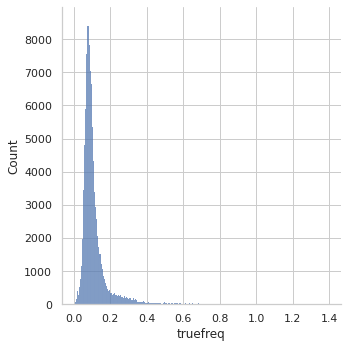

In [ ]:
sns.displot(data = claim, x = 'truefreq')

## Shallow



In [ ]:
# hyperparametres
batch = 1000
epoch = 100
q1 = 20 # 8

In [ ]:
Design = tf.keras.Input(shape=(41,), name = 'Design')
LogVol = tf.keras.Input(shape=(1,), name = 'LogVol')
layer1  = layers.Dense(5, activation = 'tanh', name = 'Layer1')(Design)
Network = layers.Dense(1, activation= 'linear', name = 'Network', 
                        kernel_initializer = tf.keras.initializers.Constant(0.),
                        bias_initializer =
                        tf.keras.initializers.Constant(np.log(lambda_hat)))(layer1)
addition = layers.add([Network, LogVol], name = 'Add')
response = layers.Dense(1, activation='exponential'
, name = 'Response', trainable=False, kernel_initializer = tf.keras.initializers.Constant(1.),
 bias_initializer = tf.keras.initializers.Constant(0.))(addition)
shallow = keras.Model(
    inputs = [Design,LogVol],
    outputs = response
)
shallow.compile(loss = 'poisson', optimizer = tf.keras.optimizers.Nadam(
    learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=None))

shallow.build(input_shape=(41,))
shallow.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Design (InputLayer)             [(None, 41)]         0                                            
__________________________________________________________________________________________________
Layer1 (Dense)                  (None, 5)            210         Design[0][0]                     
__________________________________________________________________________________________________
Network (Dense)                 (None, 1)            6           Layer1[0][0]                     
__________________________________________________________________________________________________
LogVol (InputLayer)             [(None, 1)]          0                                            
____________________________________________________________________________________________

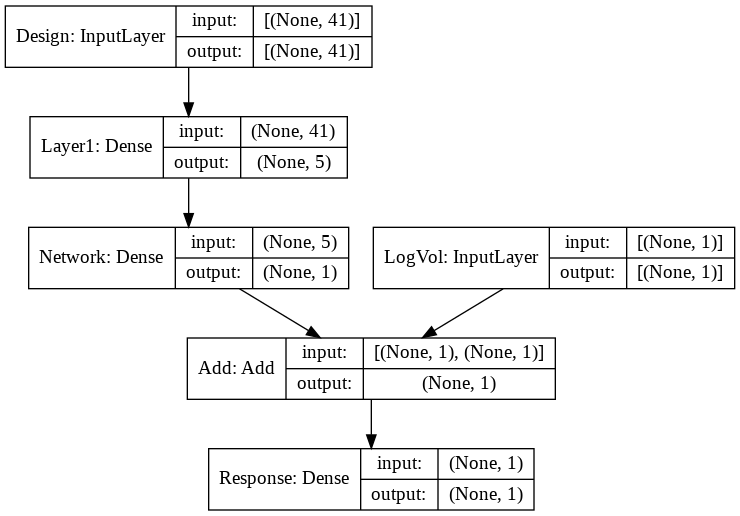

In [ ]:
keras.utils.plot_model(shallow, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
history = shallow.fit(
    x = [x, lv],
    y = y,
    #x = [x_train, lv_train],
    #y = y_train,
    #validation_data = ([x_valid, lv_valid], y_valid),
    verbose=2,
    epochs=epoch,
    batch_size = batch)

Epoch 1/100
500/500 - 1s - loss: 0.1926
Epoch 2/100
500/500 - 1s - loss: 0.1918
Epoch 3/100
500/500 - 1s - loss: 0.1917
Epoch 4/100
500/500 - 1s - loss: 0.1917
Epoch 5/100
500/500 - 1s - loss: 0.1917
Epoch 6/100
500/500 - 1s - loss: 0.1917
Epoch 7/100
500/500 - 1s - loss: 0.1917
Epoch 8/100
500/500 - 1s - loss: 0.1917
Epoch 9/100
500/500 - 1s - loss: 0.1916
Epoch 10/100
500/500 - 1s - loss: 0.1916
Epoch 11/100
500/500 - 1s - loss: 0.1916
Epoch 12/100
500/500 - 1s - loss: 0.1916
Epoch 13/100
500/500 - 1s - loss: 0.1916
Epoch 14/100
500/500 - 1s - loss: 0.1916
Epoch 15/100
500/500 - 1s - loss: 0.1915
Epoch 16/100
500/500 - 1s - loss: 0.1915
Epoch 17/100
500/500 - 1s - loss: 0.1915
Epoch 18/100
500/500 - 1s - loss: 0.1914
Epoch 19/100
500/500 - 1s - loss: 0.1914
Epoch 20/100
500/500 - 1s - loss: 0.1914
Epoch 21/100
500/500 - 1s - loss: 0.1913
Epoch 22/100
500/500 - 1s - loss: 0.1912
Epoch 23/100
500/500 - 1s - loss: 0.1912
Epoch 24/100
500/500 - 1s - loss: 0.1911
Epoch 25/100
500/500 - 1s

In [ ]:
shallow.save('/content/drive/MyDrive/models/shallow_32')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/shallow_32/assets


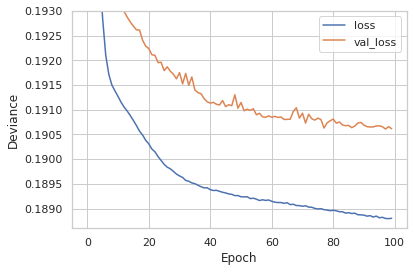

In [ ]:
plot_loss(history, yran=[0.1886, 0.1930], val = True)

In [ ]:
predictions = shallow.predict([x,lv])

In [ ]:
preds = predictions.flatten()
# mean of predicted claims
preds.mean()

0.053084563

In [ ]:
preds.max()


0.4101158

In [ ]:
# in sample deviance
deviance(preds / v, v, y)

0.28024056721800217

In [ ]:
# eps
deviance(preds, v , truefreq, eps = True)

0.0038377746015047067

## Deep

In [ ]:
# hyperparametre
batch = 1000
epoch = 100
q1 = 20
q2 = 10
q3 = 8

In [ ]:
Design = tf.keras.Input(shape=(41,), name = 'Design')
LogVol = tf.keras.Input(shape=(1,), name = 'LogVol')
layer1  = layers.Dense(q1, activation = 'tanh', name = 'Layer1')(Design)
layer2  = layers.Dense(q2, activation= 'tanh',  name = 'Layer2')(layer1)
layer3  = layers.Dense(q3, activation= 'tanh',  name = 'Layer3')(layer2)
Network = layers.Dense(1, activation= 'linear', name = 'Network', 
                        kernel_initializer = tf.keras.initializers.Constant(0.),
 bias_initializer = tf.keras.initializers.Constant(np.log(lambda_hat)))(layer3)
addition = layers.add([Network, LogVol], name = 'Add')
response = layers.Dense(1, activation='exponential'
, name = 'Response', trainable=False, kernel_initializer = tf.keras.initializers.Constant(1.),
 bias_initializer = tf.keras.initializers.Constant(0.))(addition)
deep = keras.Model(
    inputs = [Design,LogVol],
    outputs = response
)

deep.compile(loss = 'poisson', optimizer = tf.keras.optimizers.Nadam(
    learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=None))

deep.build(input_shape=(41,))
deep.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Design (InputLayer)             [(None, 41)]         0                                            
__________________________________________________________________________________________________
Layer1 (Dense)                  (None, 20)           840         Design[0][0]                     
__________________________________________________________________________________________________
Layer2 (Dense)                  (None, 10)           210         Layer1[0][0]                     
__________________________________________________________________________________________________
Layer3 (Dense)                  (None, 8)            88          Layer2[0][0]                     
____________________________________________________________________________________________

In [ ]:
# initial first bad guess
'''
model = keras.Sequential([
                          layers.InputLayer(input_shape=(41,)),
                          layers.Dense(20, activation = 'tanh'),
                          layers.Dense(15, activation= 'tanh'),
                          layers.Dense(10, activation= 'tanh'),
                          layers.Dense(1, activation= 'linear'),
                          layers.Dense(units = 1, activation= 'exponential', trainable=False)

])
model.compile(loss = 'poisson', optimizer = tf.keras.optimizers.Nadam(
    learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07))

'''

"\nmodel = keras.Sequential([\n                          layers.InputLayer(input_shape=(41,)),\n                          layers.Dense(20, activation = 'tanh'),\n                          layers.Dense(15, activation= 'tanh'),\n                          layers.Dense(10, activation= 'tanh'),\n                          layers.Dense(1, activation= 'linear'),\n                          layers.Dense(units = 1, activation= 'exponential', trainable=False)\n\n])\nmodel.compile(loss = 'poisson', optimizer = tf.keras.optimizers.Nadam(\n    learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07))\n\n"

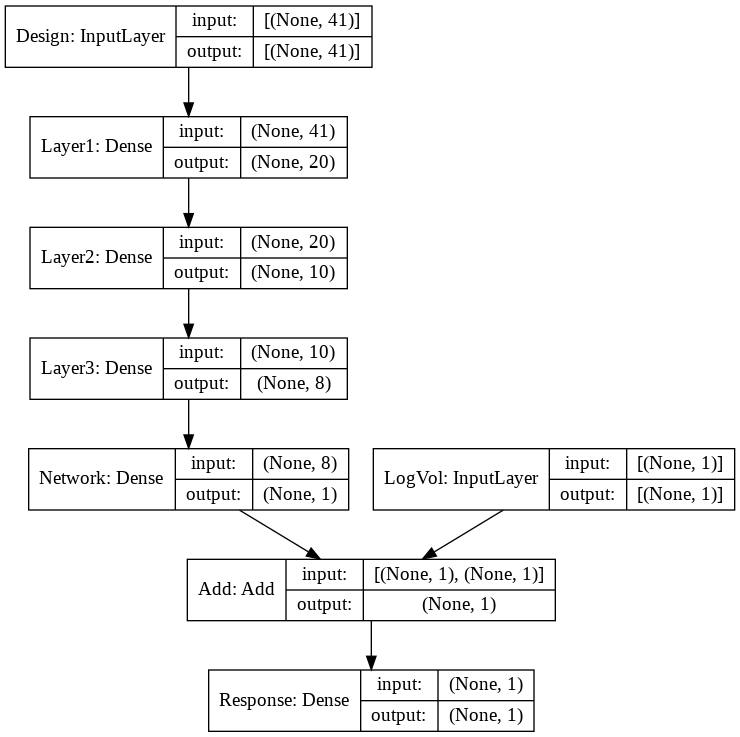

In [ ]:
keras.utils.plot_model(deep, "multi_input_and_output_model.png", show_shapes=True)

### Full dataset

In [ ]:
%%time

history = deep.fit(
    x = [x, lv],
    y = y,
    #x_train, y_train,
    #validation_data = (x_valid, y_valid),
    verbose=2,
    epochs=epoch,
    batch_size = batch)

Epoch 1/100
500/500 - 2s - loss: 0.1922
Epoch 2/100
500/500 - 1s - loss: 0.1914
Epoch 3/100
500/500 - 1s - loss: 0.1907
Epoch 4/100
500/500 - 1s - loss: 0.1902
Epoch 5/100
500/500 - 1s - loss: 0.1899
Epoch 6/100
500/500 - 1s - loss: 0.1898
Epoch 7/100
500/500 - 1s - loss: 0.1896
Epoch 8/100
500/500 - 1s - loss: 0.1896
Epoch 9/100
500/500 - 1s - loss: 0.1895
Epoch 10/100
500/500 - 1s - loss: 0.1894
Epoch 11/100
500/500 - 1s - loss: 0.1894
Epoch 12/100
500/500 - 1s - loss: 0.1893
Epoch 13/100
500/500 - 1s - loss: 0.1893
Epoch 14/100
500/500 - 1s - loss: 0.1893
Epoch 15/100
500/500 - 1s - loss: 0.1893
Epoch 16/100
500/500 - 1s - loss: 0.1892
Epoch 17/100
500/500 - 1s - loss: 0.1892
Epoch 18/100
500/500 - 1s - loss: 0.1892
Epoch 19/100
500/500 - 1s - loss: 0.1891
Epoch 20/100
500/500 - 1s - loss: 0.1891
Epoch 21/100
500/500 - 1s - loss: 0.1891
Epoch 22/100
500/500 - 1s - loss: 0.1891
Epoch 23/100
500/500 - 1s - loss: 0.1891
Epoch 24/100
500/500 - 1s - loss: 0.1890
Epoch 25/100
500/500 - 1s

In [ ]:
deep_full.save('/content/drive/MyDrive/models/deep1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/deep1/assets


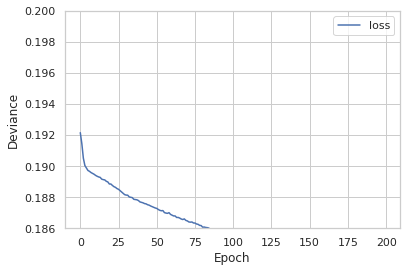

In [ ]:
plot_loss(history, yran=[0.186, 0.2], val = False)

In [ ]:
predictions = deep.predict([x,lv])

In [ ]:
preds = predictions.flatten()
# mean of predicted claims
preds.mean()

0.051582538

In [ ]:
preds.max()


0.8455306

In [ ]:
# in sample deviance
deviance(preds / v, v, y)

0.27661915508799556

In [ ]:
# eps
deviance(preds, v , truefreq, eps = True)

878.760751612073


0.0034561210560226014

In [ ]:
tf.keras.backend.set_epsilon(1e-7)


In [ ]:
class DenseLayer(pf.Module):

    def __init__(self, d_in: int, d_out: int):

        self.w = pf.Parameter([d_in, d_out])
        self.b = pf.Parameter([1, d_out])

    def __call__(self, x):
        return x @ self.w() + self.b()

class Linearizer(pf.Module):
  
  def __init__(self, d_in, d_out):

        self.w = pf.Parameter(shape = [d_in, d_out],
                          prior = pf.Normal(0, 1/15000),
                          )
        self.b = pf.Parameter(shape = [1, d_out], 
                          prior = pf.Normal(lambda_hat, 1/15000),
                          )
    
  def __call__(self,x):
        return x @ self.w() + self.b()


class DenseNetwork(pf.Module):

    def __init__(self, dims):
        Nl = len(dims) - 1 #number of layers
        self.layers = [pf.Dense(dims[i], dims[i+1]) for i in range(Nl)]
        self.activations = (Nl - 1) * [tf.nn.relu]
        self.activations += [tf.math.softplus] # toto robi ze z vystupu poslednej vrstvy idie identita
        #self.last_layer = Linearizer(Nl, Nl + 1)

    def __call__(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            x = self.activations[i](x)
        #x = self.last_layer(x)
        #x = self.activations[len(self.activations) - 1](x)
        return x

class DenserRegression(pf.ContinuousModel):

    def __init__(self, dims):
        self.net = DenseNetwork(dims)

    def __call__(self, x):
        return pf.Poisson(self.net(x))

In [ ]:
bayes_first = DenserRegression([42,20,10,8,1])

In [ ]:
bayes_first.net

In [ ]:
xx = x
xx['v'] = v
# Record the ELBO
monitor_elbo = pf.MonitorELBO()

# Record the mean absolute error on validation data
monitor_mae = pf.MonitorMetric('mae', x, y)

# Anneal the learning rate from ~2e-4 to ~0
lr_scheduler = pf.LearningRateScheduler(lambda e: 2e-4-2e-6*e)

# List of callbacks
callbacks = [monitor_elbo, monitor_mae]
xx

,age,ac,power,gas,area,dens,brand_B10,brand_B11,brand_B12,brand_B13,brand_B14,brand_B2,brand_B3,brand_B4,brand_B5,brand_B6,ct_AI,ct_AR,ct_BE,ct_BL,ct_BS,ct_FR,ct_GE,ct_GL,ct_GR,ct_JU,ct_LU,ct_NE,ct_NW,ct_OW,ct_SG,ct_SH,ct_SO,ct_SZ,ct_TG,ct_TI,ct_UR,ct_VD,ct_VS,ct_ZG,ct_ZH,v
0,0.333333,-0.771429,-0.636364,-0.5,-0.6,-0.133866,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.33
1,-0.638889,-0.942857,0.090909,0.5,-1.0,-0.308800,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.08
2,0.166667,-0.657143,-0.272727,0.5,-0.2,0.059857,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.92
3,0.333333,-0.771429,-0.818182,0.5,-0.2,0.106561,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.00
4,0.250000,-0.828571,-0.272727,-0.5,-0.6,-0.156363,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,-0.611111,-0.828571,-0.818182,0.5,-0.2,0.042402,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.15
499996,-0.388889,-0.885714,-0.818182,-0.5,0.2,0.259335,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.86
499997,-0.222222,-0.600000,-0.454545,-0.5,-0.2,0.072617,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.74
499998,0.500000,-0.714286,-0.636364,0.5,-0.6,-0.109472,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1.00


In [ ]:
%%time
bayes_first.fit(xx, y, epochs= 100, batch_size=1024, callbacks=callbacks, num_workers=4, eager = True)

CPU times: user 49min 6s, sys: 25min 2s, total: 1h 14min 9s
Wall time: 1h 12min 49s


In [ ]:
vysledky = bayes_first.predict(xx)

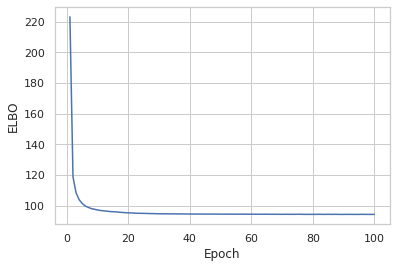

In [ ]:
monitor_elbo.plot()

In [ ]:
vysledky.mean()

NameError: ignored

In [ ]:
bayes_first.pred_dist_plot(xx.values[128:129,:], n = 10000)

InvalidArgumentError: ignored

In [ ]:
testik.predictive_sample(xx[10:20])

InvalidArgumentError: ignored

In [ ]:
claim['vysledky'] = vysledky

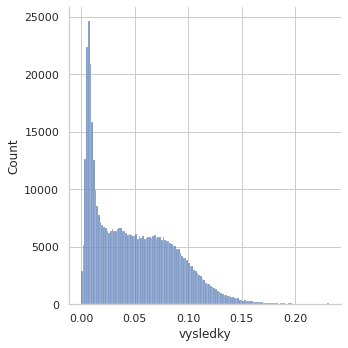

In [ ]:
sns.displot(claim, x = 'vysledky')

In [ ]:
# in sample deviance
deviance(vysledky / v, v, y)